In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']= 100
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import ujson as json
import os
from tqdm import tqdm_notebook


IDs: MB 307; TK 337 \
https://docs.google.com/spreadsheets/d/15e1K0tg5ponA5R6YQkZfihrShTDLAKf5qeKaoVCiuhQ/edit#gid=0

In [2]:
#Team name, using IDs above: mlcourse_ai_fall2019_team_<id1>_…<id4> 

In [3]:
train_X = pd.read_csv('/Users/m/Insight/MLcourse/Dota/train_features_plus.csv', index_col='match_id_hash')
test_X = pd.read_csv('/Users/m/Insight/MLcourse/Dota/test_features_plus.csv', index_col='match_id_hash')
target =  pd.read_csv('/Users/m/Insight/MLcourse/Dota/targets_plus.csv', index_col='match_id_hash')
y = target['radiant_win']

In [4]:
train_X_ability = pd.read_csv('/Users/m/Insight/MLcourse/Dota/train_features_ability.csv', index_col = 'match_id_hash')
test_X_ability = pd.read_csv('/Users/m/Insight/MLcourse/Dota/test_features_ability.csv', index_col = 'match_id_hash')

In [5]:
train_X = train_X.merge(train_X_ability, how='outer', left_index=True, right_index = True)
test_X = test_X.merge(test_X_ability, how='outer', left_index=True, right_index = True)

In [6]:
full_df = train_X.merge(pd.DataFrame(y), how='outer', left_index=True, right_index=True)
full_df.shape

(39675, 406)

In [7]:
full_df_copy = full_df.copy()
test_X_copy = test_X.copy()

In [8]:
#features columns
ls_feature_cols = list(train_X.columns.values)

In [10]:
ls_feature_cols;

In [11]:
ls_feature_remove = []

In [12]:
#hero id columns names
ls_r_hero_id = ['r{}_hero_id'.format(i) for i in range(1,6)]
ls_d_hero_id = ['d{}_hero_id'.format(i) for i in range(1,6)]
ls_hero_id = ls_r_hero_id + ls_d_hero_id

In [13]:
hero_ids = full_df[ls_hero_id +['radiant_win']]
hero_ids_rad_win = hero_ids[hero_ids['radiant_win'] == True]
hero_ids_rad_lose = hero_ids[hero_ids['radiant_win'] == False]
#hero_ids_rad_win.shape[0] + hero_ids_rad_lose.shape[0]

In [14]:
winning_hero_ids1 = hero_ids_rad_win[ls_r_hero_id]
winning_hero_ids2 = hero_ids_rad_lose[ls_d_hero_id]
#winning_hero_ids1.shape[0] + winning_hero_ids2.shape[0]

In [15]:
losing_hero_ids1 = hero_ids_rad_win[ls_d_hero_id]
losing_hero_ids2 = hero_ids_rad_lose[ls_r_hero_id]

In [16]:
winning_hero_ids1.rename(columns = {'r1_hero_id':'1_id', 'r2_hero_id':'2_id', 
                              'r3_hero_id':'3_id','r4_hero_id':'4_id',
                                    'r5_hero_id':'5_id'}, inplace = True)
winning_hero_ids2.rename(columns = {'d1_hero_id':'1_id', 'd2_hero_id':'2_id', 
                              'd3_hero_id':'3_id','d4_hero_id':'4_id',
                                    'd5_hero_id':'5_id'}, inplace = True)

In [17]:
losing_hero_ids1.rename(columns = {'d1_hero_id':'1_id', 'd2_hero_id':'2_id', 
                              'd3_hero_id':'3_id','d4_hero_id':'4_id',
                                    'd5_hero_id':'5_id'}, inplace = True)
losing_hero_ids2.rename(columns = {'r1_hero_id':'1_id', 'r2_hero_id':'2_id', 
                              'r3_hero_id':'3_id','r4_hero_id':'4_id',
                                    'r5_hero_id':'5_id'}, inplace = True)

In [18]:
winning_hero_ids = pd.concat([winning_hero_ids1, winning_hero_ids2], axis=0)
winning_hero_ids.shape

(39675, 5)

In [19]:
losing_hero_ids = pd.concat([losing_hero_ids1, losing_hero_ids2], axis=0)
losing_hero_ids.shape

(39675, 5)

In [20]:
winning_hero_counts = winning_hero_ids['1_id'].value_counts().sort_index() + winning_hero_ids['2_id'].value_counts().sort_index() + winning_hero_ids['3_id'].value_counts().sort_index() + winning_hero_ids['4_id'].value_counts().sort_index() + winning_hero_ids['5_id'].value_counts().sort_index()

In [21]:
losing_hero_counts = losing_hero_ids['1_id'].value_counts().sort_index() + losing_hero_ids['2_id'].value_counts().sort_index() + losing_hero_ids['3_id'].value_counts().sort_index() + losing_hero_ids['4_id'].value_counts().sort_index() + losing_hero_ids['5_id'].value_counts().sort_index()

In [22]:
winning_hero_counts = winning_hero_counts.sort_values()
winning_hero_dict = winning_hero_counts.to_dict()

In [23]:
losing_hero_counts = losing_hero_counts.sort_values()
losing_hero_dict = losing_hero_counts.to_dict()

In [24]:
hero_counts_win_minus_lose = winning_hero_counts.sort_index() - losing_hero_counts.sort_index()
diff_hero_dict = hero_counts_win_minus_lose.to_dict()

In [25]:
from collections import Counter
total_games_dict = Counter(winning_hero_dict) + Counter(losing_hero_dict)
hero_id_normalize_dict = {k: (diff_hero_dict[k] / total_games_dict[k]) for k in diff_hero_dict}

In [26]:
#run this cell only once! or else NaNs
for col in ls_hero_id:
    if col not in ls_feature_cols:
        ls_feature_cols.append(col+'_bool')
    ls_feature_cols.append(col+'success')
    full_df[col+'success'] = full_df[col].map(diff_hero_dict)
    train_X[col+'success'] = train_X[col].map(diff_hero_dict)
    test_X[col+'success'] = test_X[col].map(diff_hero_dict)

In [27]:
#run only once!
for col in ls_hero_id:
    if col not in ls_feature_cols:
        ls_feature_cols.append(col+'_bool')
    ls_feature_cols.append(col+'norm')
    full_df[col+'norm'] = full_df[col].map(hero_id_normalize_dict)
    train_X[col+'norm'] = train_X[col].map(hero_id_normalize_dict)
    test_X[col+'norm'] = test_X[col].map(hero_id_normalize_dict)

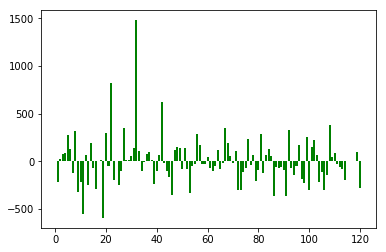

In [28]:
plt.bar(list(diff_hero_dict.keys()), diff_hero_dict.values(), color='g')
plt.show()

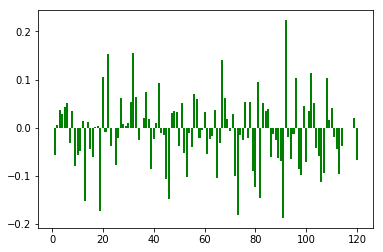

In [29]:
plt.bar(list(hero_id_normalize_dict.keys()), hero_id_normalize_dict.values(), color='g')
plt.show()

In [30]:
ls_top_heros = [k for k,v in hero_id_normalize_dict.items() if v > 0.1] + [k for k,v in diff_hero_dict.items() if v > 500]

In [31]:
ls_bottom_heros = [k for k,v in hero_id_normalize_dict.items() if v < -0.09] + [k for k,v in diff_hero_dict.items() if v < -500]

In [32]:
ls_bottom_heros

[13, 19, 45, 46, 53, 65, 72, 73, 80, 82, 91, 98, 106, 107, 113, 11, 19]

In [32]:
for col in ls_hero_id:
    if col not in ls_feature_cols:
        ls_feature_cols.append(col+'_bool')
    full_df[col+'_bool'] = np.where(full_df[col].astype(int).isin(ls_top_heros),2,np.where(full_df[col].isin(ls_bottom_heros),0,1))
    train_X[col+'_bool'] = np.where(train_X[col].astype(int).isin(ls_top_heros),2,np.where(train_X[col].isin(ls_bottom_heros),0,1))
    test_X[col+'_bool'] = np.where(test_X[col].astype(int).isin(ls_top_heros),2,np.where(test_X[col].isin(ls_bottom_heros),0,1))

If using one-hot encoder, need nonnegative values, so 2 = top, 0 = bottom, 1 = none of these

In [33]:
train_X.shape

(39675, 435)

In [34]:
full_df.shape

(39675, 436)

In [35]:
test_X.shape

(10000, 435)

In [36]:
ls_feature_cols.append('r_hero_idnorm')
full_df['r_hero_idnorm'] = full_df[['r{}_hero_idnorm'.format(i) for i in range(1,6)]].sum(axis=1)
train_X['r_hero_idnorm'] = train_X[['r{}_hero_idnorm'.format(i) for i in range(1,6)]].sum(axis=1)
test_X['r_hero_idnorm'] = test_X[['r{}_hero_idnorm'.format(i) for i in range(1,6)]].sum(axis=1)

In [37]:
ls_feature_cols.append('d_hero_idnorm')
full_df['d_hero_idnorm'] = full_df[['d{}_hero_idnorm'.format(i) for i in range(1,6)]].sum(axis=1)
train_X['d_hero_idnorm'] = train_X[['d{}_hero_idnorm'.format(i) for i in range(1,6)]].sum(axis=1)
test_X['d_hero_idnorm'] = test_X[['d{}_hero_idnorm'.format(i) for i in range(1,6)]].sum(axis=1)

### Look at hero success, taken k heros per team

Heros are numbered from 1 to 120.

### k=2 at a time

In [38]:
import itertools

In [39]:
heros_df_r_win = hero_ids[hero_ids['radiant_win']==True]
heros_df_r_lose = hero_ids[hero_ids['radiant_win']==False]

In [40]:
r_heros_df_r_win = heros_df_r_win[ls_r_hero_id]
r_heros_df_r_lose = heros_df_r_lose[ls_r_hero_id]
d_heros_df_r_win = heros_df_r_win[ls_d_hero_id]
d_heros_df_r_lose = heros_df_r_lose[ls_d_hero_id]

In [41]:
r_heros_df_r_win.values.sort()
r_heros_df_r_lose.values.sort()
d_heros_df_r_win.values.sort()
d_heros_df_r_lose.values.sort()

In [42]:
def make_2tuple(df,x,hero_id_list):
    df['{}_hero_2tuple_1'.format(x)] = list(zip(df.loc[:,'{}1_hero_id'.format(x)],df.loc[:,'{}2_hero_id'.format(x)]))
    df['{}_hero_2tuple_2'.format(x)] = list(zip(df.loc[:,'{}1_hero_id'.format(x)],df.loc[:,'{}3_hero_id'.format(x)]))
    df['{}_hero_2tuple_3'.format(x)] = list(zip(df.loc[:,'{}1_hero_id'.format(x)],df.loc[:,'{}4_hero_id'.format(x)]))
    df['{}_hero_2tuple_4'.format(x)] = list(zip(df.loc[:,'{}1_hero_id'.format(x)],df.loc[:,'{}5_hero_id'.format(x)]))
    df['{}_hero_2tuple_5'.format(x)] = list(zip(df.loc[:,'{}2_hero_id'.format(x)],df.loc[:,'{}3_hero_id'.format(x)]))
    df['{}_hero_2tuple_6'.format(x)] = list(zip(df.loc[:,'{}2_hero_id'.format(x)],df.loc[:,'{}4_hero_id'.format(x)]))
    df['{}_hero_2tuple_7'.format(x)] = list(zip(df.loc[:,'{}2_hero_id'.format(x)],df.loc[:,'{}5_hero_id'.format(x)]))
    df['{}_hero_2tuple_8'.format(x)] = list(zip(df.loc[:,'{}3_hero_id'.format(x)],df.loc[:,'{}4_hero_id'.format(x)]))
    df['{}_hero_2tuple_9'.format(x)] = list(zip(df.loc[:,'{}3_hero_id'.format(x)],df.loc[:,'{}5_hero_id'.format(x)]))
    df['{}_hero_2tuple_10'.format(x)] = list(zip(df.loc[:,'{}4_hero_id'.format(x)],df.loc[:,'{}5_hero_id'.format(x)]))
    for col in hero_id_list:
        if col in df.columns.values and col.startswith(x):
            df.drop(col,axis=1,inplace=True)
    return df

In [43]:
r_heros_df_r_win = make_2tuple(r_heros_df_r_win,'r',ls_hero_id);
r_heros_df_r_lose = make_2tuple(r_heros_df_r_lose,'r',ls_hero_id);
d_heros_df_r_win = make_2tuple(d_heros_df_r_win,'d',ls_hero_id);
d_heros_df_r_lose = make_2tuple(d_heros_df_r_lose,'d',ls_hero_id);

In [44]:
d_heros_df_r_lose.columns;

In [45]:
ls_tuple_cols_r = ['r_hero_2tuple_{}'.format(i) for i in range(1,11)]
ls_tuple_cols_d = ['d_hero_2tuple_{}'.format(i) for i in range(1,11)]
ls_tuple_cols = ls_tuple_cols_r + ls_tuple_cols_d

In [46]:
dict_2heros = {}
for i in range(r_heros_df_r_win.shape[0]):
    for j in ls_tuple_cols_r:
        if r_heros_df_r_win[j].iloc[i] not in dict_2heros:
            dict_2heros[r_heros_df_r_win[j].iloc[i]] = 1
        else:
            dict_2heros[r_heros_df_r_win[j].iloc[i]] +=1
for i in range(r_heros_df_r_lose.shape[0]):
    for j in ls_tuple_cols_r:
        if r_heros_df_r_lose[j].iloc[i] not in dict_2heros:
            dict_2heros[r_heros_df_r_lose[j].iloc[i]] = -1
        else:
            dict_2heros[r_heros_df_r_lose[j].iloc[i]] += -1
for i in range(d_heros_df_r_win.shape[0]):
    for j in ls_tuple_cols_d:
        if d_heros_df_r_win[j].iloc[i] not in dict_2heros:
            dict_2heros[d_heros_df_r_win[j].iloc[i]] = 1
        else:
            dict_2heros[d_heros_df_r_win[j].iloc[i]] += -1
for i in range(d_heros_df_r_lose.shape[0]):
    for j in ls_tuple_cols_d:
        if d_heros_df_r_lose[j].iloc[i] not in dict_2heros:
            dict_2heros[d_heros_df_r_lose[j].iloc[i]] = -1
        else:
            dict_2heros[d_heros_df_r_lose[j].iloc[i]] += 1

In [47]:
max(dict_2heros.values())
min(dict_2heros.values())

-111

In [48]:
len(list(dict_2heros.keys()))

6555

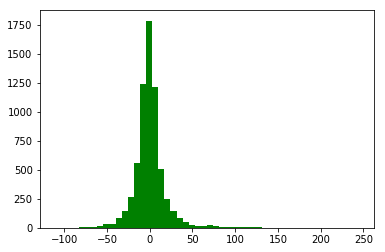

In [49]:
plt.hist(list(dict_2heros.values()), color='g',bins=50)
plt.show()

In [50]:
dict_2heros_total_games = {}
for i in range(r_heros_df_r_win.shape[0]):
    for j in ls_tuple_cols_r:
        if r_heros_df_r_win[j].iloc[i] not in dict_2heros_total_games:
            dict_2heros_total_games[r_heros_df_r_win[j].iloc[i]] = 1
        else:
            dict_2heros_total_games[r_heros_df_r_win[j].iloc[i]] +=1
for i in range(r_heros_df_r_lose.shape[0]):
    for j in ls_tuple_cols_r:
        if r_heros_df_r_lose[j].iloc[i] not in dict_2heros_total_games:
            dict_2heros_total_games[r_heros_df_r_lose[j].iloc[i]] = 1
        else:
            dict_2heros_total_games[r_heros_df_r_lose[j].iloc[i]] += 1
for i in range(d_heros_df_r_win.shape[0]):
    for j in ls_tuple_cols_d:
        if d_heros_df_r_win[j].iloc[i] not in dict_2heros_total_games:
            dict_2heros_total_games[d_heros_df_r_win[j].iloc[i]] = 1
        else:
            dict_2heros_total_games[d_heros_df_r_win[j].iloc[i]] += 1
for i in range(d_heros_df_r_lose.shape[0]):
    for j in ls_tuple_cols_d:
        if d_heros_df_r_lose[j].iloc[i] not in dict_2heros_total_games:
            dict_2heros_total_games[d_heros_df_r_lose[j].iloc[i]] = 1
        else:
            dict_2heros_total_games[d_heros_df_r_lose[j].iloc[i]] += 1

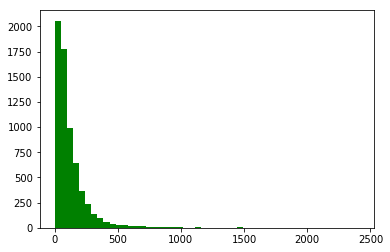

In [51]:
plt.hist(list(dict_2heros_total_games.values()), color='g',bins=50)
plt.show()

In [52]:
dict_2heros_norm = {k: dict_2heros[k]/dict_2heros_total_games[k] for k in dict_2heros}

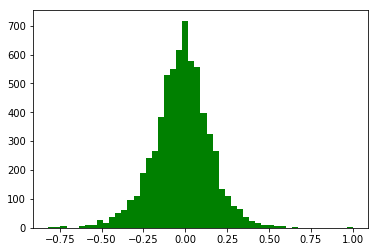

In [53]:
plt.hist(list(dict_2heros_norm.values()), color='g',bins=50)
plt.show()

In [54]:
ls_top_tuples_net2 = [k for k,v in dict_2heros.items() if v >=30]
ls_top_tuples_norm2 = [k for k,v in dict_2heros_norm.items() if v >=0.30]
ls_top_tuples2 = list(set(ls_top_tuples_net2).intersection(set(ls_top_tuples_norm2)))

In [55]:
ls_bottom_tuples_net2 = [k for k,v in dict_2heros.items() if v <= -30]
ls_bottom_tuples_norm2 = [k for k,v in dict_2heros_norm.items() if v <= -0.30]
ls_bottom_tuples2 = list(set(ls_bottom_tuples_net2).intersection(set(ls_bottom_tuples_norm2)))

In [56]:
len(ls_top_tuples2)

25

In [57]:
def make_2tuple_no_drop(df,x):
    df['{}_hero_2tuple_1'.format(x)] = list(zip(df.loc[:,'{}1_hero_id'.format(x)],df.loc[:,'{}2_hero_id'.format(x)]))
    df['{}_hero_2tuple_2'.format(x)] = list(zip(df.loc[:,'{}1_hero_id'.format(x)],df.loc[:,'{}3_hero_id'.format(x)]))
    df['{}_hero_2tuple_3'.format(x)] = list(zip(df.loc[:,'{}1_hero_id'.format(x)],df.loc[:,'{}4_hero_id'.format(x)]))
    df['{}_hero_2tuple_4'.format(x)] = list(zip(df.loc[:,'{}1_hero_id'.format(x)],df.loc[:,'{}5_hero_id'.format(x)]))
    df['{}_hero_2tuple_5'.format(x)] = list(zip(df.loc[:,'{}2_hero_id'.format(x)],df.loc[:,'{}3_hero_id'.format(x)]))
    df['{}_hero_2tuple_6'.format(x)] = list(zip(df.loc[:,'{}2_hero_id'.format(x)],df.loc[:,'{}4_hero_id'.format(x)]))
    df['{}_hero_2tuple_7'.format(x)] = list(zip(df.loc[:,'{}2_hero_id'.format(x)],df.loc[:,'{}5_hero_id'.format(x)]))
    df['{}_hero_2tuple_8'.format(x)] = list(zip(df.loc[:,'{}3_hero_id'.format(x)],df.loc[:,'{}4_hero_id'.format(x)]))
    df['{}_hero_2tuple_9'.format(x)] = list(zip(df.loc[:,'{}3_hero_id'.format(x)],df.loc[:,'{}5_hero_id'.format(x)]))
    df['{}_hero_2tuple_10'.format(x)] = list(zip(df.loc[:,'{}4_hero_id'.format(x)],df.loc[:,'{}5_hero_id'.format(x)]))
    return df

In [58]:
full_df = make_2tuple_no_drop(full_df,'r')
train_X = make_2tuple_no_drop(train_X,'r')
test_X = make_2tuple_no_drop(test_X,'r')

In [59]:
full_df = make_2tuple_no_drop(full_df,'d')
train_X = make_2tuple_no_drop(train_X,'d')
test_X = make_2tuple_no_drop(test_X,'d')

In [60]:
for col in ls_tuple_cols:
    if col not in ls_tuple_cols:
        ls_feature_cols.append(col+'_bool')
    full_df[col+'_bool'] = np.where(full_df[col].isin(ls_top_tuples2),2,np.where(full_df[col].isin(ls_bottom_tuples2),0,1))
    train_X[col+'_bool'] = np.where(train_X[col].isin(ls_top_tuples2),2,np.where(train_X[col].isin(ls_bottom_tuples2),0,1))
    test_X[col+'_bool'] = np.where(test_X[col].isin(ls_top_tuples2),2,np.where(test_X[col].isin(ls_bottom_tuples2),0,1))

In [61]:
#run only once or else nans, or maybe don't run at all (noise)
#for col in ls_tuple_cols:
#    ls_feature_cols.append(col+'_map')
#    full_df[col+'_map'] = full_df[col].map(dict_2heros)
#    train_X[col+'_map'] = train_X[col].map(dict_2heros)
#    test_X[col+'_map'] = test_X[col].map(dict_2heros)

In [62]:
ls_feature_cols.append(ls_tuple_cols)

In [63]:
full_df.shape

(39675, 478)

In [64]:
train_X.shape

(39675, 477)

In [65]:
test_X.shape

(10000, 477)

### k=3 at a time

In [66]:
r_heros_df_r_win3 = heros_df_r_win[ls_r_hero_id]
r_heros_df_r_lose3 = heros_df_r_lose[ls_r_hero_id]
d_heros_df_r_win3 = heros_df_r_win[ls_d_hero_id]
d_heros_df_r_lose3 = heros_df_r_lose[ls_d_hero_id]
r_heros_df_r_win3.values.sort()
r_heros_df_r_lose3.values.sort()
d_heros_df_r_win3.values.sort()
d_heros_df_r_lose3.values.sort()

In [67]:
from itertools import combinations

In [68]:
def make_3tuple(df,x,hero_id_list):
    combs = list(combinations([i for i in range(1,6)],3))
    i = 0
    for comb in combs:
        df['{}_hero_3tuple_{}'.format(x,i+1)] = \
                list(zip(df.loc[:,'{}{}_hero_id'.format(x,combs[i][0])],\
                         df.loc[:,'{}{}_hero_id'.format(x,combs[i][1])],
                        df.loc[:,'{}{}_hero_id'.format(x,combs[i][2])]))
        i += 1
    for col in hero_id_list:
        if col in df.columns.values and col.startswith(x):
            df.drop(col,axis=1,inplace=True)
    return df

In [69]:
#run once
r_heros_df_r_win3 = make_3tuple(r_heros_df_r_win3,'r',ls_hero_id);
r_heros_df_r_lose3 = make_3tuple(r_heros_df_r_lose3,'r',ls_hero_id);
d_heros_df_r_win3 = make_3tuple(d_heros_df_r_win3,'d',ls_hero_id);
d_heros_df_r_lose3 = make_3tuple(d_heros_df_r_lose3,'d',ls_hero_id);
d_heros_df_r_lose3.columns

Index(['d_hero_3tuple_1', 'd_hero_3tuple_2', 'd_hero_3tuple_3',
       'd_hero_3tuple_4', 'd_hero_3tuple_5', 'd_hero_3tuple_6',
       'd_hero_3tuple_7', 'd_hero_3tuple_8', 'd_hero_3tuple_9',
       'd_hero_3tuple_10'],
      dtype='object')

In [70]:
ls_tuple_cols_r3 = ['r_hero_3tuple_{}'.format(i) for i in range(1,11)]
ls_tuple_cols_d3 = ['d_hero_3tuple_{}'.format(i) for i in range(1,11)]
ls_tuple_cols3 = ls_tuple_cols_r3 + ls_tuple_cols_d3

In [71]:
dict_3heros = {}
for i in range(r_heros_df_r_win3.shape[0]):
    for j in ls_tuple_cols_r3:
        if r_heros_df_r_win3[j].iloc[i] not in dict_3heros:
            dict_3heros[r_heros_df_r_win3[j].iloc[i]] = 1
        else:
            dict_3heros[r_heros_df_r_win3[j].iloc[i]] +=1
for i in range(r_heros_df_r_lose3.shape[0]):
    for j in ls_tuple_cols_r3:
        if r_heros_df_r_lose3[j].iloc[i] not in dict_3heros:
            dict_3heros[r_heros_df_r_lose3[j].iloc[i]] = -1
        else:
            dict_3heros[r_heros_df_r_lose3[j].iloc[i]] += -1
for i in range(d_heros_df_r_win3.shape[0]):
    for j in ls_tuple_cols_d3:
        if d_heros_df_r_win3[j].iloc[i] not in dict_3heros:
            dict_3heros[d_heros_df_r_win3[j].iloc[i]] = 1
        else:
            dict_3heros[d_heros_df_r_win3[j].iloc[i]] += -1
for i in range(d_heros_df_r_lose3.shape[0]):
    for j in ls_tuple_cols_d3:
        if d_heros_df_r_lose3[j].iloc[i] not in dict_3heros:
            dict_3heros[d_heros_df_r_lose3[j].iloc[i]] = -1
        else:
            dict_3heros[d_heros_df_r_lose3[j].iloc[i]] += 1

In [72]:
print(max(dict_3heros.values()))
print(min(dict_3heros.values()))
print(len(list(dict_3heros.keys())))

32
-24
178259


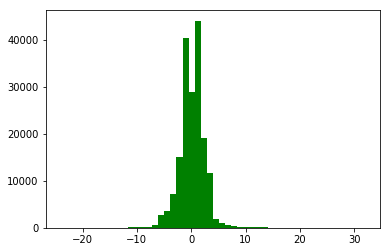

In [78]:
plt.hist(list(dict_3heros.values()), color='g',bins=50)
plt.show()

In [79]:
dict_3heros_total_games = {}
for i in range(r_heros_df_r_win.shape[0]):
    for j in ls_tuple_cols_r3:
        if r_heros_df_r_win3[j].iloc[i] not in dict_3heros_total_games:
            dict_3heros_total_games[r_heros_df_r_win3[j].iloc[i]] = 1
        else:
            dict_3heros_total_games[r_heros_df_r_win3[j].iloc[i]] +=1
for i in range(r_heros_df_r_lose3.shape[0]):
    for j in ls_tuple_cols_r3:
        if r_heros_df_r_lose3[j].iloc[i] not in dict_3heros_total_games:
            dict_3heros_total_games[r_heros_df_r_lose3[j].iloc[i]] = 1
        else:
            dict_3heros_total_games[r_heros_df_r_lose3[j].iloc[i]] += 1
for i in range(d_heros_df_r_win3.shape[0]):
    for j in ls_tuple_cols_d3:
        if d_heros_df_r_win3[j].iloc[i] not in dict_3heros_total_games:
            dict_3heros_total_games[d_heros_df_r_win3[j].iloc[i]] = 1
        else:
            dict_3heros_total_games[d_heros_df_r_win3[j].iloc[i]] += 1
for i in range(d_heros_df_r_lose3.shape[0]):
    for j in ls_tuple_cols_d3:
        if d_heros_df_r_lose3[j].iloc[i] not in dict_3heros_total_games:
            dict_3heros_total_games[d_heros_df_r_lose3[j].iloc[i]] = 1
        else:
            dict_3heros_total_games[d_heros_df_r_lose3[j].iloc[i]] += 1

In [80]:
dict_3heros_norm = {k: dict_3heros[k]/dict_3heros_total_games[k] for k in dict_3heros}

In [81]:
ls_top_tuples_net3 = [k for k,v in dict_3heros.items() if v >=15]
ls_top_tuples_norm3 = [k for k,v in dict_3heros_norm.items() if v >=0.15]
ls_top_tuples3 = list(set(ls_top_tuples_net3).intersection(set(ls_top_tuples_norm3)))
len(ls_top_tuples3)

117

In [82]:
ls_bottom_tuples_net3 = [k for k,v in dict_3heros.items() if v <= -12]
ls_bottom_tuples_norm3 = [k for k,v in dict_3heros_norm.items() if v <= -0.12]
ls_bottom_tuples3 = list(set(ls_bottom_tuples_net3).intersection(set(ls_bottom_tuples_norm3)))
len(ls_bottom_tuples3)

120

In [83]:
def make_3tuple_no_drop(df,x):
    combs = list(combinations([i for i in range(1,6)],3))
    i = 0
    for comb in combs:
        df['{}_hero_3tuple_{}'.format(x,i+1)] = \
                list(zip(df.loc[:,'{}{}_hero_id'.format(x,combs[i][0])],\
                         df.loc[:,'{}{}_hero_id'.format(x,combs[i][1])],
                        df.loc[:,'{}{}_hero_id'.format(x,combs[i][2])]))
        i += 1
    return df

full_df = make_3tuple_no_drop(full_df,'r')
train_X = make_3tuple_no_drop(train_X,'r')
test_X = make_3tuple_no_drop(test_X,'r')

full_df = make_3tuple_no_drop(full_df,'d')
train_X = make_3tuple_no_drop(train_X,'d')
test_X = make_3tuple_no_drop(test_X,'d')

In [84]:
for col in ls_tuple_cols3:
    if col not in ls_tuple_cols3:
        ls_feature_cols.append(col+'_bool')
    full_df[col+'_bool'] = np.where(full_df[col].isin(ls_top_tuples3),2,np.where(full_df[col].isin(ls_bottom_tuples3),0,1))
    train_X[col+'_bool'] = np.where(train_X[col].isin(ls_top_tuples3),2,np.where(train_X[col].isin(ls_bottom_tuples3),0,1))
    test_X[col+'_bool'] = np.where(test_X[col].isin(ls_top_tuples3),2,np.where(test_X[col].isin(ls_bottom_tuples3),0,1))

In [85]:
ls_tuple_cols_bool = [col+'_bool' for col in ls_tuple_cols]
ls_tuple_cols_bool3 = [col+'_bool' for col in ls_tuple_cols3]

In [86]:
ls_tuple_cols_bool_r = ls_tuple_cols_bool[0:10]
ls_tuple_cols_bool_d = ls_tuple_cols_bool[10:20]
ls_tuple_cols_bool3_r = ls_tuple_cols_bool3[0:10]
ls_tuple_cols_bool3_d = ls_tuple_cols_bool3[10:20]

In [87]:
full_df['r_2tuple_bool_sum'] = full_df[ls_tuple_cols_bool_r].sum(axis=1)
train_X['r_2tuple_bool_sum'] = train_X[ls_tuple_cols_bool_r].sum(axis=1)
test_X['r_2tuple_bool_sum'] = test_X[ls_tuple_cols_bool_r].sum(axis=1)

In [88]:
full_df['d_2tuple_bool_sum'] = full_df[ls_tuple_cols_bool_d].sum(axis=1)
train_X['d_2tuple_bool_sum'] = train_X[ls_tuple_cols_bool_d].sum(axis=1)
test_X['d_2tuple_bool_sum'] = test_X[ls_tuple_cols_bool_d].sum(axis=1)

In [89]:
full_df['r_3tuple_bool_sum'] = full_df[ls_tuple_cols_bool3_r].sum(axis=1)
train_X['r_3tuple_bool_sum'] = train_X[ls_tuple_cols_bool3_r].sum(axis=1)
test_X['r_3tuple_bool_sum'] = test_X[ls_tuple_cols_bool3_r].sum(axis=1)

In [90]:
full_df['d_3tuple_bool_sum'] = full_df[ls_tuple_cols_bool3_d].sum(axis=1)
train_X['d_3tuple_bool_sum'] = train_X[ls_tuple_cols_bool3_d].sum(axis=1)
test_X['d_3tuple_bool_sum'] = test_X[ls_tuple_cols_bool3_d].sum(axis=1)

In [91]:
#run only once or else nans; actually, don't run at all to avoid overfitting
#for col in ls_tuple_cols3:
#    ls_feature_cols.append(col+'_map')
#    full_df[col+'_map'] = full_df[col].map(dict_3heros)
#    train_X[col+'_map'] = train_X[col].map(dict_3heros)
#    test_X[col+'_map'] = test_X[col].map(dict_3heros)

#ls_feature_cols.append(ls_tuple_cols3)

In [92]:
full_df.shape

(39675, 522)

In [93]:
train_X.shape

(39675, 521)

In [94]:
test_X.shape

(10000, 521)

Also add feature of normalized hero id (divide by total games for each hero)

Now have mapped hero id's to how often they participate in winning games, so will now be a numeric feature and can also use sum of this as a new feature.

## Using json files for new features: already collected, do not re-run

In [40]:
with open(os.path.join('/Users/m/Insight/MLcourse/Dota/train_matches.jsonl')) as fin:
    # read the 18-th line
    for i in range(14,18):
        line = fin.readline()
    
    # read JSON into a Python object 
    match = json.loads(line)

In [41]:
match.keys()

dict_keys(['game_time', 'match_id_hash', 'teamfights', 'objectives', 'chat', 'game_mode', 'lobby_type', 'players', 'targets'])

### Working with `damage` and `damage_taken`

In [70]:
#sum 
sum(match['players'][5]['damage'].values())

36761

In [66]:
#number of damage

len(match['players'][5]['damage'].values())

22

In [69]:
sum(match['players'][5]['damage_taken'].values())

5379

In [68]:
len(match['players'][5]['damage_taken'].values())

23

Get the info for one player

In [72]:
player = match['players'][2]
num_damage = len(player['damage'].values())
num_damage_taken = len(player['damage_taken'].values())
damage = sum(player['damage'].values())
damage_taken = sum(player['damage_taken'].values())
damage_net = damage - damage_taken
print(num_damage,num_damage_taken,damage,damage_taken,damage_net)

7 5 14140 2157 11983


In [73]:
def read_matches(matches_file):
    
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    total_matches = MATCHES_COUNT.get(filename)
    
    with open(matches_file) as fin:
        for line in tqdm_notebook(fin, total=total_matches):
            yield json.loads(line)

In [74]:
matches_file = '/Users/m/Insight/MLcourse/Dota/train_matches.jsonl'

In [78]:
import collections

In [79]:
def extract_features_damage(match):
    row = [
        ('match_id_hash', match['match_id_hash']),
    ]
    
    for slot, player in enumerate(match['players']):
        if slot < 5:
            player_name = 'r%d' % (slot + 1)
        else:
            player_name = 'd%d' % (slot - 4)
            
        num_damage = len(player['damage'].values())
        num_damage_taken = len(player['damage_taken'].values())
        damage = sum(player['damage'].values())
        damage_taken = sum(player['damage_taken'].values())
        damage_net = damage - damage_taken
        
        row.append((f'{player_name}_num_damage', num_damage))
        row.append((f'{player_name}_num_damage_taken', num_damage_taken))
        row.append((f'{player_name}_damage', damage))
        row.append((f'{player_name}_damage_taken', damage_taken))
        row.append((f'{player_name}_damage_net', damage_net))
    
    return collections.OrderedDict(row)

In [80]:
json_feats = []
for match in read_matches(matches_file):
    match_id_hash = match['match_id_hash']
    features = extract_features_damage(match)
    json_feats.append(features)
df_json_feats = pd.DataFrame(json_feats).set_index('match_id_hash')

In [81]:
matches_file_test = '/Users/m/Insight/MLcourse/Dota/test_matches.jsonl'

In [82]:
json_feats_test = []
for match in read_matches(matches_file_test):
    match_id_hash = match['match_id_hash']
    features = extract_features_damage(match)
    json_feats_test.append(features)
df_json_feats_test = pd.DataFrame(json_feats_test).set_index('match_id_hash')

In [83]:
#export_csv = df_json_feats.to_csv(r'/Users/m/Insight/MLcourse/Dota/train_features_damage.csv', index = 'match_id_hash', header=True)

In [84]:
#export_csv = df_json_feats.to_csv(r'/Users/m/Insight/MLcourse/Dota/train_features_damage.csv', index = 'match_id_hash', header=True)

In [86]:
train_X_damage = df_json_feats
test_X_damage = df_json_feats_test

In [87]:
train_X_damage.columns

Index(['r1_num_damage', 'r1_num_damage_taken', 'r1_damage', 'r1_damage_taken',
       'r1_damage_net', 'r2_num_damage', 'r2_num_damage_taken', 'r2_damage',
       'r2_damage_taken', 'r2_damage_net', 'r3_num_damage',
       'r3_num_damage_taken', 'r3_damage', 'r3_damage_taken', 'r3_damage_net',
       'r4_num_damage', 'r4_num_damage_taken', 'r4_damage', 'r4_damage_taken',
       'r4_damage_net', 'r5_num_damage', 'r5_num_damage_taken', 'r5_damage',
       'r5_damage_taken', 'r5_damage_net', 'd1_num_damage',
       'd1_num_damage_taken', 'd1_damage', 'd1_damage_taken', 'd1_damage_net',
       'd2_num_damage', 'd2_num_damage_taken', 'd2_damage', 'd2_damage_taken',
       'd2_damage_net', 'd3_num_damage', 'd3_num_damage_taken', 'd3_damage',
       'd3_damage_taken', 'd3_damage_net', 'd4_num_damage',
       'd4_num_damage_taken', 'd4_damage', 'd4_damage_taken', 'd4_damage_net',
       'd5_num_damage', 'd5_num_damage_taken', 'd5_damage', 'd5_damage_taken',
       'd5_damage_net'],
      dtype

In [91]:
train_X_damage_agg = pd.DataFrame(index = train_X.index)
test_X_damage_agg = pd.DataFrame(index = test_X.index)
ls_feat_damage_agg = [i.replace("1","") for i in train_X_damage.columns.values if (i.startswith('r1')==1 
                                                                    or i.startswith('d1')==1)]
for feature in list(ls_feat_damage_agg):
    feat_names = [(feature[0] + '{}_'.format(i) + feature[2:]) for i in range(1,6)]
    train_X_damage_agg[feature] = train_X_damage.loc[:,feat_names].sum(axis=1)
    test_X_damage_agg[feature] = test_X_damage.loc[:,feat_names].sum(axis=1)

In [92]:
export_csv = train_X_damage_agg.to_csv('train_features_damage_agg.csv', index = 'match_id_hash', header=True)

,r_num_damage,r_num_damage_taken,r_damage,r_damage_taken,r_damage_net,d_num_damage,d_num_damage_taken,d_damage,d_damage_taken,d_damage_net
match_id_hash,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,20,17,8736,4242,4494,18,11,9445,1555,7890
b9c57c450ce74a2af79c9ce96fac144d,66,46,69765,21203,48562,70,57,46818,24459,22359


### Working with ability upgrades

For a single match, test new features:
`max_ability_dt`
`min_ability_dt`
`mean_ability_dt`
`max_ability_da`
`min_ability_da`
`mean_ability_da`

In [661]:
player = match['players'][2]
n = len(player['ability_upgrades'])
first_ability_time = player['ability_upgrades'][0]['time']
last_ability_time = player['ability_upgrades'][n-1]['time']
ability_dt = [first_ability_time]
#time differences between level changes
for i in range(n-1):
    diff = player['ability_upgrades'][i+1]['time'] - player['ability_upgrades'][i]['time']
    ability_dt.append(diff)
min_ability_dt = min(ability_dt)
max_ability_dt = max(ability_dt)
mean_ability_dt = sum(ability_dt)/len(ability_dt)
print(min_ability_dt,mean_ability_dt,max_ability_dt,last_ability_time)
#ability differences between level changes
ability_d_ability = [player['ability_upgrades'][0]['ability']]
last_ability = player['ability_upgrades'][n-1]['ability']
for i in range(n-1):
    diff = player['ability_upgrades'][i+1]['ability'] - player['ability_upgrades'][i]['ability']
    ability_d_ability.append(diff)
min_ability_d_ability = min(ability_d_ability)
max_ability_d_ability = max(ability_d_ability)
mean_ability_d_ability = sum(ability_d_ability)/len(ability_d_ability)
print(min_ability_d_ability,mean_ability_d_ability,max_ability_d_ability,last_ability)

4 120.5625 227 1929
-1352 314.5625 5032 5033


In [663]:
#player['ability_upgrades']

In [717]:
def read_matches(matches_file):
    
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    total_matches = MATCHES_COUNT.get(filename)
    
    with open(matches_file) as fin:
        for line in tqdm_notebook(fin, total=total_matches):
            yield json.loads(line)

In [718]:
matches_file = '/Users/m/Insight/MLcourse/Dota/train_matches.jsonl'

In [791]:
def extract_features_csv(match):
    row = [
        ('match_id_hash', match['match_id_hash']),
    ]
    
    for slot, player in enumerate(match['players']):
        if slot < 5:
            player_name = 'r%d' % (slot + 1)
        else:
            player_name = 'd%d' % (slot - 4)
            
        n = len(player['ability_upgrades'])
        if n > 0:    
            first_ability_time = player['ability_upgrades'][0]['time']
            row.append((f'{player_name}_first_ability_t', first_ability_time))
            last_ability_time = player['ability_upgrades'][n-1]['time']
            row.append((f'{player_name}_last_ability_t', last_ability_time))
            ability_dt = [first_ability_time]
            #time differences between level changes
            for i in range(n-1):
                diff = player['ability_upgrades'][i+1]['time'] - player['ability_upgrades'][i]['time']
                ability_dt.append(diff)
            min_ability_dt = min(ability_dt)
            row.append((f'{player_name}_min_ability_dt', min_ability_dt))
            max_ability_dt = max(ability_dt)
            row.append((f'{player_name}_max_ability_dt', max_ability_dt))
            mean_ability_dt = sum(ability_dt)/len(ability_dt)
            row.append((f'{player_name}_mean_ability_dt', mean_ability_dt))

            #ability differences between level changes
            first_ability = player['ability_upgrades'][0]['ability']
            row.append((f'{player_name}_first_ability', first_ability))
            last_ability = player['ability_upgrades'][n-1]['ability']
            row.append((f'{player_name}_last_ability', last_ability))
            dability = []
            for i in range(n-1):
                diff = player['ability_upgrades'][i+1]['ability'] - player['ability_upgrades'][i]['ability']
                dability.append(diff)
            try:
                min_ability_da = min(dability)
            except:
                min_ability_da = 0
            row.append((f'{player_name}_min_ability_da', min_ability_da))
            try:
                max_ability_da = max(dability)
            except:
                max_ability_da = 0
            row.append((f'{player_name}_max_ability_da', max_ability_da))
            try:
                mean_ability_da = sum(dability)/len(dability)
            except:
                mean_ability_da = 0
            row.append((f'{player_name}_mean_ability_da', mean_ability_da))
        else:
            row.append((f'{player_name}_first_ability_t', 0))
            row.append((f'{player_name}_last_ability_t', 0))
            row.append((f'{player_name}_min_ability_dt', 0))
            row.append((f'{player_name}_max_ability_dt', 0))
            row.append((f'{player_name}_mean_ability_dt', 0))

            row.append((f'{player_name}_first_ability', 0))
            row.append((f'{player_name}_last_ability', 0))
            row.append((f'{player_name}_min_ability_da', 0))
            row.append((f'{player_name}_max_ability_da', 0))
            row.append((f'{player_name}_mean_ability_da', 0))
    
    return collections.OrderedDict(row)

In [792]:
json_feats = []
for match in read_matches(matches_file):
    match_id_hash = match['match_id_hash']
    features = extract_features_csv(match)
    json_feats.append(features)
df_json_feats = pd.DataFrame(json_feats).set_index('match_id_hash')

In [794]:
#export_csv = df_json_feats.to_csv(r'/Users/m/Insight/MLcourse/Dota/train_features_ability.csv', index = 'match_id_hash', header=True)

In [796]:
matches_file_test = '/Users/m/Insight/MLcourse/Dota/test_matches.jsonl'

In [797]:
json_feats_test = []
for match in read_matches(matches_file_test):
    match_id_hash = match['match_id_hash']
    features = extract_features_csv(match)
    json_feats_test.append(features)
df_json_feats_test = pd.DataFrame(json_feats_test).set_index('match_id_hash')

In [798]:
#export_csv_test = df_json_feats_test.to_csv(r'/Users/m/Insight/MLcourse/Dota/test_features_ability.csv', index = 'match_id_hash', header=True)

In [34]:
#test on a few features
matches = []

with open(os.path.join('/Users/m/Insight/MLcourse/Dota/train_matches.jsonl')) as fin:
    for j in range(5):
        for i in range(j):
            line = fin.readline()

        # read JSON into a Python object 
        matches.append(json.loads(line))

len(matches)

NameError: name 'line' is not defined

In [786]:
json_feats = []
for match in matches:
    match_id_hash = match['match_id_hash']
    features = extract_features_csv(match)
    json_feats.append(features)
DF = pd.DataFrame(json_feats).set_index('match_id_hash')
DF.head()

,r1_first_ability_t,r1_last_ability_t,r1_min_ability_dt,r1_max_ability_dt,r1_mean_ability_dt,r1_first_ability,r1_last_ability,r1_min_ability_da,r1_max_ability_da,r1_mean_ability_da,...,d5_first_ability_t,d5_last_ability_t,d5_min_ability_dt,d5_max_ability_dt,d5_mean_ability_dt,d5_first_ability,d5_last_ability,d5_min_ability_da,d5_max_ability_da,d5_mean_ability_da
match_id_hash,,,,,,,,,,,,,,,,,,,,,
7469e9440ea3d19b211a484647c7126e,230,984,76,262,164.0,5353,5356,-2,2,0.6,...,228,1033,47,228,103.3,5098,6926,-2,1828,203.111111
a400b8f29dece5f4d266f49f1ae2e98a,0,0,0,0,0.0,0,0,0,0,0.0,...,0,0,0,0,0.0,0,0,0,0,0.000000
6db558535151ea18ca70a6892197db41,0,0,0,0,0.0,0,0,0,0,0.0,...,0,0,0,0,0.0,0,0,0,0,0.000000
19c39fe2af2b547e48708ca005c6ae74,0,0,0,0,0.0,0,0,0,0,0.0,...,0,0,0,0,0.0,0,0,0,0,0.000000
7469e9440ea3d19b211a484647c7126e,230,984,76,262,164.0,5353,5356,-2,2,0.6,...,228,1033,47,228,103.3,5098,6926,-2,1828,203.111111


## Find new features:

1. Use data from `match['teamfights']`. This could be hard because nothing specific here about  teams, would have to link teamfights to players.
2. Hero data:
Find best hero combinations for winning games

### Creating new features

In [95]:
test_X.shape

(10000, 521)

In [96]:
train_X.shape

(39675, 521)

In [97]:
full_df.shape

(39675, 522)

In [98]:
train_test_feat = pd.concat([full_df.drop('radiant_win',axis=1),test_X])
train_test_feat.shape

(49675, 521)

In [99]:
def select_cols_n_distinct(data,min,max):
    '''select columns in data frame with number of 
    distinct values between min and max, inclusive'''
    cols = []
    for col in data.columns.values:
        unique_vals = data[col].value_counts().shape[0]
        if unique_vals >= min and unique_vals <= max:
            #cols.append((col,unique_vals))
            cols.append(col)
    return cols    

In [100]:
select_cols_n_distinct(full_df.drop('radiant_win',axis=1),2,2);

In [101]:
radiant_win_T = full_df[full_df['radiant_win'] == 1]['lobby_type']
radiant_win_F = full_df[full_df['radiant_win'] == 0]['lobby_type']
#sns.distplot(radiant_win_T, bins=100, label='R won')
#sns.distplot(radiant_win_F, bins=100, label='R lost')
#plt.xlim(1900, 2020)
#plt.legend()

In [102]:
#sns.countplot(x="lobby_type", hue="radiant_win", data=full_df);

In [103]:
new_features = pd.DataFrame(index=train_test_feat.index)

In [237]:
#ls_new_feats = [i.replace("1","")  for i in full_df.columns.values if (i.startswith('r1')==1 
         #                                                           or i.startswith('d1')==1)]
ls_new_feats_sum = [i.replace("1","")+'_sum' for i in full_df.columns.values if (i.startswith('r1')==1 
                                                                    or i.startswith('d1')==1)]
ls_new_feats_max = [i.replace("1","")+'_max' for i in full_df.columns.values if (i.startswith('r1')==1 
                                                                    or i.startswith('d1')==1)]
ls_new_feats_min = [i.replace("1","")+'_min' for i in full_df.columns.values if (i.startswith('r1')==1 
                                                                    or i.startswith('d1')==1)]
ls_new_feats_range = [i.replace("1","")+'_range' for i in full_df.columns.values if (i.startswith('r1')==1 
                                                                    or i.startswith('d1')==1)]

Create a feature that is sum of r1 + ... + r5 for all r features, and same for all d features. Note that not all of these make sense, so some should be removed.

In [117]:
for feature in ls_new_feats_sum:
    feat_names = [(feature[0] + '{}_'.format(i) + feature[2:-4]) for i in range(1,6)]
    new_features[feature] = train_test_feat.loc[:,feat_names].sum(axis=1)
for feature in ls_new_feats_max:
    feat_names = [(feature[0] + '{}_'.format(i) + feature[2:-4]) for i in range(1,6)]
    new_features[feature] = train_test_feat.loc[:,feat_names].sum(axis=1)
for feature in ls_new_feats_min:
    feat_names = [(feature[0] + '{}_'.format(i) + feature[2:-4]) for i in range(1,6)]
    new_features[feature] = train_test_feat.loc[:,feat_names].sum(axis=1)
for feature in ls_new_feats_range:
    feat_names = [(feature[0] + '{}_'.format(i) + feature[2:-4]) for i in range(1,6)]
    new_features[feature] = train_test_feat.loc[:,feat_names].sum(axis=1)
   # new_features[feature + '_mean'] = train_test_feat.loc[:,feat_names].mean(axis=1)
   #new_features[feature + '_std'] = train_test_feat.loc[:,feat_names].std(axis=1)
#new_features.drop(['r_hero_id','d_hero_id'],inplace=True,axis=1)

In [118]:
len(new_features.columns)
#new_features.isnull().sum().sum()

344

# New features from TK

## Transform Health

In [119]:
health = ['r{}_health'.format(x) for x in range(1,6)] +['d{}_health'.format(x) for x in range(1,6)]
max_health = ['r{}_health'.format(x) for x in range(1,6)] +['d{}_health'.format(x) for x in range(1,6)]
x = ['r{}_x'.format(x) for x in range(1,6)] +['d{}_x'.format(x) for x in range(1,6)]
y1 = ['r{}_y'.format(x) for x in range(1,6)] +['d{}_y'.format(x) for x in range(1,6)]
xp = ['r{}_xp'.format(x) for x in range(1,6)] +['d{}_xp'.format(x) for x in range(1,6)]

train_positions = train_X[health+max_health+x+y1+xp]
#train_positions.head(2)

In [120]:
def are_dead(x):
    ans = 0 
    for el in x:
        if el == 0:
            ans += 1
    return ans

In [121]:
d_health = ['d{}_health'.format(i) for i in range(1,6)]
new_features['d_dead'] = full_df[d_health].apply(are_dead, axis = 1)
r_health = ['r{}_health'.format(i) for i in range(1,6)]
new_features['r_dead'] = full_df[r_health].apply(are_dead, axis = 1)

In [122]:
# calculate the proportion of health
percentage_health = 0
for j in range(5):
    max_health = '{}_max_health'.format(d_health[j].split('_')[0])
    health = 'd{}_health'.format(j+1)
    ph = full_df[health]/full_df[max_health]
    percentage_health += 1/5*ph

new_features['d_health_avg'] = percentage_health

percentage_health = 0
for j in range(5):
    max_health = '{}_max_health'.format(r_health[j].split('_')[0])
    health = 'r{}_health'.format(j+1)
    ph = full_df[health]/full_df[max_health]
    percentage_health += 1/5*ph

new_features['r_health_avg'] = percentage_health

In [123]:
ls_feature_cols.append(['d_dead','r_dead','d_health_avg','r_health_avg'])

### In opponent's base

In [124]:
def in_opponent_base(x,y,opponent = 'Radiant'):

    '''
returns indicator function of whether the player is in the base of the opponent
opponent = {'Radiant', 'Dire'} - opponent team
    
    '''
#     x = coordinates[0]
#     y = coordinates[1]
    radiant_base_x = 96
    radiant_base_y = 100

    dire_base_x = 156
    dire_base_y = 156

    if opponent == 'Radiant':
        if x <= radiant_base_x and y <= radiant_base_y:
            return 1
        else:
            return 0
    elif opponent == 'Dire':
        if x >= dire_base_x and y >= dire_base_y:
            return 1
        else:
            return 0
    else:
        return NaN

In [125]:
r_x = ['r{}_x'.format(j) for j in range(1,6)]
r_y = ['r{}_y'.format(j) for j in range(1,6)]
d_x = ['d{}_x'.format(j) for j in range(1,6)]
d_y = ['d{}_y'.format(j) for j in range(1,6)]
# getting indicator function for each player
# !!!!!!!!!!!!!!!!!!!!!!! Do not run if using the small set only

for j in range(5):
    rx = r_x[j]
    ry = r_y[j]
    dx = d_x[j]
    dy = d_y[j]
    full_df['r{}_in_d_base'.format(j+1)] = full_df.loc[:,[rx,ry]].apply(lambda x: in_opponent_base(x = x[rx], y = x[ry], opponent = 'Dire'), axis = 1)
    full_df['d{}_in_r_base'.format(j+1)] = full_df.loc[:,[dx,dy]].apply(lambda x: in_opponent_base(x = x[dx], y = x[dy], opponent = 'Radiant'), axis = 1)
    full_df['r{}_in_r_base'.format(j+1)] = full_df.loc[:,[rx,ry]].apply(lambda x: in_opponent_base(x = x[rx], y = x[ry], opponent = 'Radiant'), axis = 1)
    full_df['d{}_in_d_base'.format(j+1)] = full_df.loc[:,[dx,dy]].apply(lambda x: in_opponent_base(x = x[dx], y = x[dy], opponent = 'Dire'), axis = 1)
    
    full_df['r{}_in_d_base_hero_id'.format(j+1)] = full_df['r{}_in_d_base'.format(j+1)]*full_df['r{}_hero_id'.format(j+1)]
    full_df['d{}_in_r_base_hero_id'.format(j+1)] = full_df['d{}_in_r_base'.format(j+1)]*full_df['d{}_hero_id'.format(j+1)]
    
    full_df['r{}_in_d_base_count_ability_use'.format(j+1)] = full_df['r{}_in_d_base'.format(j+1)]*full_df['r{}_count_ability_use'.format(j+1)]
    full_df['d{}_in_r_base_count_ability_use'.format(j+1)] = full_df['d{}_in_r_base'.format(j+1)]*full_df['d{}_count_ability_use'.format(j+1)]
    
    full_df['r{}_in_d_max_hero_hit'.format(j+1)] = full_df['r{}_in_d_base'.format(j+1)]*full_df['r{}_max_hero_hit'.format(j+1)]
    full_df['d{}_in_r_max_hero_hit'.format(j+1)] = full_df['d{}_in_r_base'.format(j+1)]*full_df['d{}_max_hero_hit'.format(j+1)]
    
    full_df['r{}_in_d_damage_dealt'.format(j+1)] = full_df['r{}_in_d_base'.format(j+1)]*full_df['r{}_damage_dealt'.format(j+1)]
    full_df['d{}_in_r_damage_dealt'.format(j+1)] = full_df['d{}_in_r_base'.format(j+1)]*full_df['d{}_damage_dealt'.format(j+1)]
    
    full_df['r{}_in_r_damage_received'.format(j+1)] = full_df['r{}_in_r_base'.format(j+1)]*full_df['r{}_damage_received'.format(j+1)]
    full_df['d{}_in_d_damage_received'.format(j+1)] = full_df['d{}_in_d_base'.format(j+1)]*full_df['d{}_damage_received'.format(j+1)]

In [126]:
# getting total amount of players of each team at each base

r_in_d_base = pd.Series(0,index = full_df.index)
d_in_r_base = pd.Series(0,index = full_df.index)
r_in_r_base = pd.Series(0,index = full_df.index)
d_in_d_base = pd.Series(0,index = full_df.index)

for j in range(5):
    rx = r_x[j]
    ry = r_y[j]
    dx = d_x[j]
    dy = d_y[j]
    r_in_d_base += full_df.loc[:,[rx,ry]].apply(lambda x: in_opponent_base(x = x[rx], y = x[ry], opponent = 'Dire'), axis = 1)
    d_in_r_base += full_df.loc[:,[dx,dy]].apply(lambda x: in_opponent_base(x = x[dx], y = x[dy], opponent = 'Radiant'), axis = 1)
    r_in_r_base += full_df.loc[:,[rx,ry]].apply(lambda x: in_opponent_base(x = x[rx], y = x[ry], opponent = 'Radiant'), axis = 1)
    d_in_d_base += full_df.loc[:,[dx,dy]].apply(lambda x: in_opponent_base(x = x[dx], y = x[dy], opponent = 'Dire'), axis = 1)

In [127]:
new_features['r_in_d_base'] = r_in_d_base
new_features['d_in_r_base'] = d_in_r_base
new_features['r_in_r_base'] = r_in_d_base
new_features['d_in_d_base'] = d_in_r_base
ls_feature_cols.append(['r_in_d_base','r_in_r_base','d_in_r_base','d_in_d_base'])

In [128]:
r_teamfight = ['r{}_teamfight_participation'.format(j) for j in range(1,6)] 
for col in r_teamfight:
    full_df[full_df[col] >1][col] = 1

d_teamfight = ['d{}_teamfight_participation'.format(j) for j in range(1,6)] 
for col in d_teamfight:
    full_df[full_df[col] >1][col] = 1

In [129]:
ls_feature_cols.append(r_teamfight + d_teamfight)

### Create boolean features:

`*_ability_level`
`*_teamfight_participation`
`*_kills`
`*_assists`
`*_deaths`
`*_sen_placed`

In [130]:
test = pd.DataFrame()
def create_boolean_features(cols):
    for col in cols:
        new_features['boolean_' + col] = np.where(new_features[col]==0, 1, 0)
        

In [131]:
boolean_cols = ['r_ability_level','d_ability_level','r_teamfight_participation',
                'd_teamfight_participation','r_kills','d_kills',
                'r_assists','d_assists','r_deaths','d_deaths','r_sen_placed',
               'd_sen_placed']
ls_feature_cols.append(boolean_cols)
create_boolean_features(boolean_cols)

### Take log of skewed features

In [132]:
import math
col_for_log =  ['r_count_ability_use','r_max_hero_hit',
                'r_damage_received','r_damage_dealt',
                'r_max_mana','r_max_health',
                'r_lh','r_health',
     'r_gold', 'r_xp', 'r_stuns',
    'd_count_ability_use', 'd_max_hero_hit',
                'd_max_mana','d_max_health',
                'd_damage_received','d_damage_dealt',
               'd_health', 'd_stuns',
     'd_gold', 'd_lh', 'd_xp']

for col in col_for_log:
    new_log_index = 'log_{}'.format(col)
#     print(new_features[col].min())
    new_features[col] = new_features[col].apply(lambda x: math.log(x+5))
    
#train_test_feat['chat_len'] = train_test_feat['chat_len'].apply(lambda x: math.log(x+5))

Conclusions about categorical variables:
* firstblood_claimed : categorical, binary
* game_mode: categorical, non-ordinal --> needs to be converted to dummy variables
* lobby_type: categorical, binary (value 7 chould be changes with 1)
* hero_id: categorical, non-ordinal (too many levels)
* level: categorical, ordinal (25 levels)
* x,y are coordinates of players

## Combine old and new features

In [133]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [134]:
train_test_feat.shape

(49675, 521)

In [135]:
new_features.shape

(49675, 364)

In [136]:
all_feats = train_test_feat.merge(new_features, how='outer', left_index=True, right_index = True)

In [137]:
all_feats.isnull().sum().sum()

80000

In [138]:
all_feats.drop(all_feats.columns[all_feats.isnull().any()],inplace=True,axis=1)

In [139]:
all_feats.isnull().sum().sum()

0

In [140]:
all_feats.shape

(49675, 877)

### Split `all_features` into train and test data

### Drop the tuples!

In [141]:
ls_feature_remove = []
ls_feature_remove = ls_tuple_cols + ls_tuple_cols3 +['lobby_type','game_mode','chat_len','game_time','objectives_len']

In [142]:
all_feats.drop(ls_feature_remove,axis=1,inplace=True)

In [143]:
all_feats.drop(ls_hero_id,inplace=True,axis=1)

In [144]:
all_feats.shape

(49675, 822)

In [145]:
ind = train_X.shape[0]
all_feats_train = all_feats.iloc[:ind,]
all_feats_test = all_feats.iloc[ind:,:]
print(all_feats_train.shape)
print(all_feats_test.shape)

(39675, 822)
(10000, 822)


In [146]:
all_feats_full = pd.concat([all_feats_train,y],axis=1)
all_feats_full.head(1);

In [147]:
X_train, X_test, y_train, y_test = train_test_split(all_feats_full.drop('radiant_win',axis=1),
                                                    all_feats_full['radiant_win'], test_size=.3, 
                                                    stratify=all_feats_full['radiant_win'])

In [148]:
X_train.head();

In [149]:
y_train.shape

(27772,)

In [150]:
pd.DataFrame(y_train).isnull().sum()

radiant_win    0
dtype: int64

In [198]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer, LabelEncoder
from sklearn_pandas import DataFrameMapper

In [151]:
#hero_ids = ['r{}_hero_id'.format(i) for i in range(1,6)] +['d{}_hero_id'.format(i) for i in range(1,6)]
cat_feats = select_cols_n_distinct(all_feats_full,2,3)# + hero_ids
cat_feats.remove('radiant_win')
#cat_feats.append('game_mode')

#cat_feats

In [152]:
#ord_feats = select_cols_n_distinct(all_feats,4,30)
#ord_feats.remove('game_mode')

In [153]:
num_feats = [feature for feature in all_feats_full.columns.values if feature not in cat_feats]
num_feats.remove('radiant_win')
#num_feats = [feature for feature in all_feats.columns.values if feature not in ord_feats]

In [154]:
from sklearn.ensemble import AdaBoostClassifier

In [155]:
from lightgbm import LGBMClassifier
from sklearn.base import BaseEstimator

In [156]:
class ClassifierCustom(BaseEstimator):
    def __init__(self, C=1, n_estimators=200):
        self.n_estimators = n_estimators
        self.C = C
        
        self.models = []
        #self.boot = []
        #self.feat_ids_by_tree = []
    def fit(self, X, y):
            #log reg
            lr = LogisticRegression(C = self.C)
            self.models.append(lr.fit(X,y))
            
            #Adaboost
            ab = AdaBoostClassifier(n_estimators = 250, learning_rate = 1)
            self.models.append(ab.fit(X,y))
            
            #lgbm
            lgbm = LGBMClassifier(n_jobs=-1)
            self.models.append(lgbm.fit(X,y))
            return self
    
    def predict_proba(self, X):
        self.probs = [self.models[0].predict_proba(X)] #weight logistic regression double
        for i in range(len(self.models)):
            self.probs.append(self.models[i].predict_proba(X))
        self.probs = np.array(self.probs)
        self.averages = np.mean(self.probs, axis = 0)
        return self.averages
    
    def predict(self,X):
        self.predictions =  self.predict_proba(X) >=0.5 
        return self.predictions


In [229]:
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier

class Columns(BaseEstimator, TransformerMixin):
    def __init__(self, names=None):
        self.names = names

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X):
        return X[self.names]
    
    

pipe = Pipeline([
    ("features", FeatureUnion([
        ('numeric', make_pipeline(Columns(names=num_feats),StandardScaler())),
        ('categorical', make_pipeline(Columns(names=cat_feats),OneHotEncoder(sparse=False)))
    ])),
    #('PCA',PCA(n_components = 550,whiten=True)),
    ('logreg', LogisticRegression(C=.8,penalty='l1',solver='saga'))])
    #('custom', ClassifierCustom(C = 0.95, n_estimators = 250))])
    #('adaboost', AdaBoostClassifier(n_estimators = 150))])
       #('lgbm', LGBMClassifier(n_jobs=-1,boost = 'gbdt',
       #   feature_fraction= 0.05,
       #   learning_rate= 0.005,
       #     num_iterations = 500,
       #   max_depth= -1,  
       #   min_data_in_leaf = 150,
       #   num_leaves = 64,
       #   num_threads = -1,
       #   verbosity= 1,
       #   objective = 'binary'))])

In [230]:
#pipe.fit(all_feats_train,y)
pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric', Pipeline(memory=None,
     steps=[('columns', Columns(names=['r1_kills', 'r1_deaths', 'r1_assists', 'r1_denies', 'r1_gold', 'r1_lh', 'r1_xp', 'r1_health', 'r1_max_health', 'r1_max_mana', 'r1_level', 'r1_x', 'r1_y', 'r1_s...penalty='l1', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False))])

In [231]:
feature_importance = abs(pipe.named_steps['logreg'].coef_[0])

In [234]:
predicted = pipe.predict(X_test)

In [235]:
print(accuracy_score(y_test, predicted))

0.7444341762580862


In [236]:
print(roc_auc_score(y_test,predicted))

0.7428248516094558


In [198]:
from sklearn.model_selection import cross_val_predict

In [199]:
cv_pred = cross_val_predict(pipe, 
                            # X_train, 
                            # y_train, 
                             all_feats_train,
                            y,
                             cv=5,
                             method="predict_proba")

In [202]:
cv_pred.shape

(39675, 2)

In [203]:
print("Cross validation AUC {:.4f}".format(roc_auc_score(y, cv_pred[:,1])))

Cross validation AUC 0.8225


Note: So far, logreg with C = 0.95 does the best. The Custom ensemble is also close. PCA decreases both metrics and position on leaderboard; RF also decreased leaderboard position, over logreg (best so far).\
`cross_val_predict` gives ROC AUC 0.8132 for logistic regression. ROC AUC 0.8049 for lightGBM (untuned)

### Custom classifier: logreg, Adaboost, lgbm

## Grid Search

In [326]:
from sklearn.model_selection import GridSearchCV

In [80]:
param_grid_lgbm = {
    'lgbm__max_depth': [18],
    'lgbm__learning_rate': [.01],
    'lgbm__num_leaves': [4,8,16], #large will increase accuracy but may overfit
    'lgbm__learning_rate': [0.005],
    'lgbm__n_estimators': [40],
    'lgbm__num_leaves': [6,8,12,16],
    'lgbm__boosting_type' : ['gbdt'],
    'lgbm__objective' : ['binary'],
    'lgbm__random_state' : [501], # Updated from 'seed'
    'lgbm__colsample_bytree' : [0.65, 0.66],
    'lgbm__subsample' : [0.7,0.75],
    'lgbm__reg_alpha' : [1,1.2],
    'lgbm__reg_lambda' : [1,1.2,1.4],
    }

In [327]:
param_grid_logreg = {
    'logreg__C': [.6,.7,.8],
    'logreg__penalty': ['l1'],
    'logreg__solver': ['saga']   
}

In [427]:
param_grid_ab = {
    'adaboost__n_estimators': [125,150,175],
}

In [360]:
grid_clf = GridSearchCV(pipe, param_grid_logreg, cv=5, iid=False)
grid_clf.fit(X_train, y_train);

In [361]:
grid_clf.best_params_

{'logreg__C': 0.8, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}

In [362]:
print("grid search best: %f" % grid_clf.best_estimator_.score(X_test, y_test))


grid search best: 0.751239


Logistic regression is doing better than other models. In grid search with best C = 0.9.

PCA best around 300 (+-15).

AdaBoost is doing more poorly; best `n_estimators` is 150 among `[50,100,150]`

### Preparing submission

In [207]:
all_feats_test.shape

(10000, 144)

In [208]:
#X_test_vals = all_feats_test.values
y_test_pred = pipe.predict_proba(all_feats_test)[:,1]

df_submission = pd.DataFrame({'radiant_win_prob': y_test_pred}, 
                                 index=all_feats_test.index)


In [209]:
df_submission.index.name='match_id_hash'

In [210]:
df_submission.head(3)

,radiant_win_prob
match_id_hash,
30cc2d778dca82f2edb568ce9b585caa,0.362214
70e5ba30f367cea48793b9003fab9d38,0.980129
4d9ef74d3a2025d79e9423105fd73d41,0.935642


In [211]:
import datetime
submission_filename = 'submission_{}.csv'.format(
    datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
df_submission.to_csv(submission_filename)
print('Submission saved to {}'.format(submission_filename))

Submission saved to submission_2019-11-16_18-53-12.csv


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a40c5b518>]],
      dtype=object)

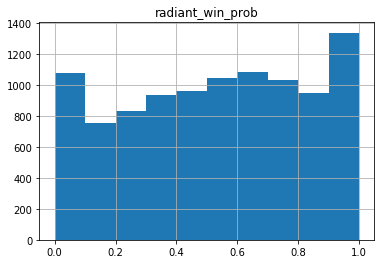

In [371]:
df_submission.hist()

Not using this:

Cross validation AUC 0.8049


In [56]:
from sklearn.compose import ColumnTransformer, make_column_transformer

preprocess = make_column_transformer(
    (num_feats, StandardScaler()),
    (cat_feats, OneHotEncoder()))



/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:751: DeprecationWarning: `make_column_transformer` now expects (transformer, columns) as input tuples instead of (columns, transformer). This has been introduced in v0.20.1. `make_column_transformer` will stop accepting the deprecated (columns, transformer) order in v0.22.
  warnings.warn(message, DeprecationWarning)


In [58]:
pipe2 = make_pipeline(
    preprocess,
   # StandardScaler(),
    LGBMClassifier(n_jobs=-1)
)

## EDA + FE

In [577]:
full_df.columns

Index(['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len',
       'r1_kills', 'r1_deaths', 'r1_assists', 'r1_denies', 'r1_gold',
       ...
       'r1_hero_idnorm', 'r2_hero_idnorm', 'r3_hero_idnorm', 'r4_hero_idnorm',
       'r5_hero_idnorm', 'd1_hero_idnorm', 'd2_hero_idnorm', 'd3_hero_idnorm',
       'd4_hero_idnorm', 'd5_hero_idnorm'],
      dtype='object', length=316)

In [578]:
full_df['game_mode'].value_counts()

22    31762
4      3564
23     2546
3      1200
2       408
5       188
12        5
16        2
Name: game_mode, dtype: int64

In [579]:
game_mode_rad_win = full_df[full_df['radiant_win'] == True]['game_mode']
game_mode_rad_lose = full_df[full_df['radiant_win'] == False]['game_mode']

In [581]:
game_mode_rad_win.value_counts(normalize=True)

22    0.803659
4     0.087871
23    0.064007
3     0.029434
2     0.010708
5     0.004177
12    0.000096
16    0.000048
Name: game_mode, dtype: float64

In [582]:
game_mode_rad_lose.value_counts(normalize=True)

22    0.797125
4     0.091994
23    0.064354
3     0.031142
2     0.009815
5     0.005358
12    0.000159
16    0.000053
Name: game_mode, dtype: float64

In [583]:
lobby_type_rad_win = full_df[full_df['radiant_win'] == True]['lobby_type']
lobby_type_rad_lose = full_df[full_df['radiant_win'] == False]['lobby_type']
print(lobby_type_rad_win.value_counts(normalize=True))
print(lobby_type_rad_lose.value_counts(normalize=True))

7    0.683569
0    0.316431
Name: lobby_type, dtype: float64
7    0.679771
0    0.320229
Name: lobby_type, dtype: float64


In [586]:
objectives_len_rad_win = full_df[full_df['radiant_win'] == True]['objectives_len']
objectives_len_rad_lose = full_df[full_df['radiant_win'] == False]['objectives_len']
#print(objectives_len_rad_win.value_counts(normalize=True))
#print(objectives_len_rad_lose.value_counts(normalize=True))

In [587]:
full_rad_win = full_df[full_df['radiant_win']==True]
full_rad_lose = full_df[full_df['radiant_win']==False]